In [1]:
import os
import typing

# Dask Configuration

In [2]:
from dask_jobqueue import PBSCluster
from pathlib import Path

# Define the working directory path
working_directory = str(Path.cwd())

# Launch a scheduler and workers on HPC via PBS
cluster = PBSCluster(
     cores=4,
     memory="8GB",
     processes=1,
     queue="tamirQ",
     walltime="02:30:00",
     scheduler_options={"dashboard_address": ":12435"},  # FIXME - this is the port we need to define...
     # Additional custom options
     log_directory="dask-logs",
     #worker_extra_args=["--lifetime", "25m", "--lifetime-stagger", "4m"],  # for walltime="00:30:00"
     job_script_prologue=[f"cd {working_directory}"]
)

In [3]:
cluster

Dashboard: http://132.66.112.146:12435/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://132.66.112.146:33818,Workers: 0
Dashboard: http://132.66.112.146:12435/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
cluster.adapt(minimum=10, maximum=60)
print(cluster.job_script())

#!/usr/bin/env bash

#PBS -N dask-worker
#PBS -q tamirQ
#PBS -l select=1:ncpus=4:mem=7630MB
#PBS -l walltime=02:30:00
#PBS -e dask-logs/
#PBS -o dask-logs/
cd /tamir2/moranb/microbiome/Igem_TAU_2021
/tamir2/moranb/microbiome/Igem_TAU_2021/venv/bin/python -m distributed.cli.dask_worker tcp://132.66.112.146:33818 --nthreads 4 --memory-limit 7.45GiB --name dummy-name --nanny --death-timeout 60



In [5]:
from dask.distributed import Client, progress, wait, get_client, get_worker
client = Client(cluster)

In [6]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://132.66.112.146:12435/status,
Dashboard: http://132.66.112.146:12435/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://132.66.112.146:33818,Workers: 0
Dashboard: http://132.66.112.146:12435/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [7]:
import dask.bag as db
import dask.dataframe as dd
from dask import delayed, compute, persist
from pandas.core.dtypes.common import pandas_dtype as dtype
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path

# Analysis for homo sapiens genes

In [8]:
import operator
from Bio import SeqIO
from analysis.input_testing_data.generate_input_testing_data_for_modules import generate_testing_data
from analysis.input_testing_data.generate_input_testing_data_for_modules import generate_testing_data_for_ecoli_and_bacillus

from modules.main import run_modules
from modules.user_IO.input_functions import extract_gene_data

In [9]:
output_path = "/tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/homo_sapiens"
optimization_cub_index = "CAI"

variant_names = [
    "{score}_single_diff",
    "{score}_zscore_single_diff",
    "{score}_zscore_bulk_diff",
    "{score}_single_ratio",
    "{score}_zscore_single_ratio",
    "{score}_zscore_bulk_ratio",
]

In [10]:
def get_configuration(is_ecoli_optimized):
    return f"e_coli_optimized_{is_ecoli_optimized}_bacillus_optimized_{not is_ecoli_optimized}"

In [11]:
def get_orf_summary(summary: typing.Dict[str, typing.Any], evaluation_method: str = "average_distance_score") -> typing.Dict[str, typing.Any]:
    if len(summary["evaluation"]) == 1:
        return summary["orf"]
    final_evaluation = summary["final_evaluation"]
    for i, evaluation_summary in enumerate(summary["evaluation"]):
        if evaluation_summary[evaluation_method] == final_evaluation[evaluation_method]:
            return summary["orf"][i]

def get_total_run_time(summary: typing.Dict[str, typing.Any]) -> float:
     if len(summary["evaluation"]) == 1:
        return summary["orf"]["run_time"]
     run_time = 0
     for orf_summary in summary["orf"]:
         run_time += orf_summary["run_time"]
     return run_time

In [12]:
def convert_json(x):
    gene_name = x["gene_name"]
    result = x["summary"]
    orf = get_orf_summary(result)
    if "orf" not in result or orf is None: # probably thrown in case of an error
        return {"error": result, "gene_name": gene_name}
    run_time = get_total_run_time(result)
    iterations_count = str(orf.get("iterations_count", 1))
    return {
        "initial_optimization_score": orf.get("initial_sequence_optimization_score"),
        "final_optimization_score": orf.get("final_sequence_optimization_score"),
        "average_distance_score": result["final_evaluation"].get("average_distance_score"),
        "average_distance_non_normalized_score": result["final_evaluation"].get("average_distance_non_normalized_score"),
        "weakest_link_score": result["final_evaluation"].get("weakest_link_score"),
        "ratio_score": result["final_evaluation"].get("ratio_score"),
        "gene_name": gene_name,
        "orf_optimization_cub_index": result["module_input"].get("orf_optimization_cub_index"),
        "evaluation_score": result["module_input"].get("evaluation_score"),
        "run_time": run_time,
        "iterations_count": iterations_count,
        "final_sequence": result["final_evaluation"].get("final_sequence"),
    }

In [13]:
def json_map(x):
    x = x.strip("\n")
    result = None
    try:
        result = json.loads(x)
        return convert_json(result)
    except Exception as e:
        return {"error_message": "bad json string", "input": x}

In [14]:
def get_df_for_run_configuration(configuration, optimization_method, is_debug=False):
    configuration_output_path = os.path.join(output_path, configuration)
    debug_suffix = '-debug' if is_debug else ''
    results_dir = F"{os.path.join(configuration_output_path, optimization_method + debug_suffix)}"
    print(f"results dir is: {results_dir}")
    file_names = [str(file) for file in list(Path(results_dir).rglob("*.json"))]
    # bag = db.read_text(file_names).map(json.loads)
    bag = db.read_text(file_names).map(json_map)

    error_records = bag.filter(lambda x: "error_message" in x.keys())
    valid_records = bag.filter(lambda x: "error_message" not in x.keys())
    return valid_records.to_dataframe().compute(), error_records.compute()

    # return dd.read_json([str(file) for file in list(Path(results_dir).rglob("*.json"))], orient='records', lines=True)

In [15]:
def get_scores_df_by_configuration_df(configuration, is_debug=False):
    df_bulk_zscore_ratio, df_bulk_zscore_ratio_errors = get_df_for_run_configuration(configuration, "zscore_bulk_aa_ratio", is_debug)
    df_bulk_zscore_diff, df_bulk_zscore_diff_errors = get_df_for_run_configuration(configuration, "zscore_bulk_aa_diff", is_debug)
    merged_bulk_zscore_df = dd.merge(df_bulk_zscore_ratio, df_bulk_zscore_diff, on='gene_name', how='inner', suffixes=('_zscore_bulk_ratio', '_zscore_bulk_diff'))

    df_single_zscore_ratio, df_single_zscore_ratio_errors = get_df_for_run_configuration(configuration, "zscore_single_aa_ratio", is_debug)
    df_single_zscore_diff, df_single_zscore_diff_errors = get_df_for_run_configuration(configuration, "zscore_single_aa_diff", is_debug)
    merged_single_zscore_df = dd.merge(df_single_zscore_ratio, df_single_zscore_diff, on='gene_name', how='inner', suffixes=('_zscore_single_ratio', '_zscore_single_diff'))

    df_single_codon_ratio, df_single_codon_ratio_error = get_df_for_run_configuration(configuration, "single_codon_ratio", is_debug)
    df_single_codon_diff, df_single_codon_diff_error = get_df_for_run_configuration(configuration, "single_codon_diff", is_debug)
    merged_single_df = dd.merge(df_single_codon_ratio, df_single_codon_diff, on='gene_name', how='inner', suffixes=('_single_ratio', '_single_diff'))

    merged_df = dd.merge(merged_bulk_zscore_df, merged_single_zscore_df, on='gene_name', how='inner')
    merged_df = dd.merge(merged_df, merged_single_df, on='gene_name', how='inner')
    # merged_df = dd.merge(merged_bulk_zscore_df, merged_single_df, on='gene_name', how='inner')
    return merged_df, [
        df_bulk_zscore_ratio_errors,
        df_bulk_zscore_diff_errors, 
        df_single_zscore_ratio_errors, 
        df_single_zscore_diff_errors, 
        df_single_codon_ratio_error,
        df_single_codon_diff_error,
    ]

In [16]:
def get_scores_df_by_configuration(configuration, is_debug=False):
    df_bulk_zscore_ratio, df_bulk_zscore_ratio_errors = get_df_for_run_configuration(configuration, "zscore_bulk_aa_ratio", is_debug)
    df_bulk_zscore_diff, df_bulk_zscore_diff_errors = get_df_for_run_configuration(configuration, "zscore_bulk_aa_diff", is_debug)

    df_single_codon_ratio, df_single_codon_ratio_error = get_df_for_run_configuration(configuration, "single_codon_ratio", is_debug)
    df_single_codon_diff, df_single_codon_diff_error = get_df_for_run_configuration(configuration, "single_codon_diff", is_debug)

    return [
        df_bulk_zscore_ratio,
        df_bulk_zscore_diff,
        df_single_codon_ratio,
        df_single_codon_diff,
    ], [
        df_bulk_zscore_ratio_errors,
        df_bulk_zscore_diff_errors, 
        df_single_zscore_ratio_errors, 
        df_single_zscore_diff_errors, 
        df_single_codon_ratio_error,
        df_single_codon_diff_error,
    ]

In [17]:
def add_median_to_histogram(value, histogram, row, col, upper_limit):
    median_value = value.median()
    histogram[row][col].axvline(median_value, color="green", linestyle="dashed", label="median")
    histogram[row][col].text(median_value-1, upper_limit, f"median={median_value}")

In [18]:
def add_median_to_histogram_non_normalized(value, histogram, row, col, upper_limit):
    median_value = value.median()
    histogram[row][col].axvline(median_value, color="green", linestyle="dashed", label="median")
    histogram[row][col].text(median_value-0.1, upper_limit, f"median={median_value}")

In [19]:
def plot_comparative_graphs(result, variant_scores):
    figure, axis = plt.subplots(8, 2, figsize=(20,35))

    index = 0
    for i, first_variant in enumerate(variant_scores):
        for j, second_variant in enumerate(variant_scores):
            if j <= i:
                continue 
            scatter = result.plot.scatter(x=first_variant, y=second_variant, ax=axis[index//2, index%2])
            r, p = stats.pearsonr(result[first_variant], result[second_variant])
            scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')
            index += 1

#### Escherichia-coli as wanted host 

In [20]:
configuration = get_configuration(is_ecoli_optimized=True)
result, errors = get_scores_df_by_configuration_df(configuration)

results dir is: /tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/homo_sapiens/e_coli_optimized_True_bacillus_optimized_False/zscore_bulk_aa_ratio


Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, ini

results dir is: /tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/homo_sapiens/e_coli_optimized_True_bacillus_optimized_False/zscore_bulk_aa_diff


Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, ini

results dir is: /tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/homo_sapiens/e_coli_optimized_True_bacillus_optimized_False/zscore_single_aa_ratio


Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, ini

results dir is: /tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/homo_sapiens/e_coli_optimized_True_bacillus_optimized_False/zscore_single_aa_diff


Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, ini

results dir is: /tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/homo_sapiens/e_coli_optimized_True_bacillus_optimized_False/single_codon_ratio


Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, ini

results dir is: /tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/homo_sapiens/e_coli_optimized_True_bacillus_optimized_False/single_codon_diff


Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, ini

In [21]:
result

,initial_optimization_score_zscore_bulk_ratio,final_optimization_score_zscore_bulk_ratio,average_distance_score_zscore_bulk_ratio,average_distance_non_normalized_score_zscore_bulk_ratio,weakest_link_score_zscore_bulk_ratio,ratio_score_zscore_bulk_ratio,gene_name,orf_optimization_cub_index_zscore_bulk_ratio,evaluation_score_zscore_bulk_ratio,run_time_zscore_bulk_ratio,...,final_optimization_score_single_diff,average_distance_score_single_diff,average_distance_non_normalized_score_single_diff,weakest_link_score_single_diff,ratio_score_single_diff,orf_optimization_cub_index_single_diff,evaluation_score_single_diff,run_time_single_diff,iterations_count_single_diff,final_sequence_single_diff
0,1.180627,2461.192747,1.530075,0.041794,1.530075,1.506487,A1BG,CAI,average_distance,60.251543,...,None,1.090409,0.105379,1.090409,1.154115,CAI,average_distance,0.022475,1,ATGTCCATGCTCGTGGTCTTTCTCTTGCTGTGGGGTGTCACCTGGG...
1,0.970581,2370.802855,2.858582,0.131672,2.858582,1.750904,A1CF,CAI,average_distance,69.220530,...,None,2.548998,0.187677,2.548998,1.352632,CAI,average_distance,0.020662,1,ATGGAAGCAGTGTGTCTGGGCACATGCCCAGAGCCAGAAGCGAGCA...
2,0.803693,2336.398241,3.081720,0.143082,3.081720,1.752917,AASS,CAI,average_distance,79.986618,...,None,2.873995,0.210625,2.873995,1.375804,CAI,average_distance,0.070749,1,ATGCTGCAAGTACATAGGACTGGACTGGGCAGGCTGGGGGTCAGCC...
3,1.195915,2341.737049,2.352755,0.103715,2.352755,1.671508,AATF,CAI,average_distance,53.584662,...,None,2.113690,0.159891,2.113690,1.317366,CAI,average_distance,0.025196,1,ATGGCGGGGCCGCAGCCCCTGGCGCTGCAACTGGAACAGTTGTTGA...
4,0.988338,2331.953191,2.744822,0.124474,2.744822,1.680162,ABHD12B,CAI,average_distance,66.786667,...,None,2.427563,0.185591,2.427563,1.316531,CAI,average_distance,0.016009,1,ATGGACGCGCAGGACTGCCAGGCGGCCGCATCGCCCGAGCCGCCCG...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20146,0.776331,2398.044183,3.287720,0.159375,3.287720,1.873397,ZZZ3,CAI,average_distance,91.485058,...,None,2.821748,0.198934,2.821748,1.397913,CAI,average_distance,0.032210,1,ATGGCTGCTTCCCGATCTACTCGTGTTACAAGATCAACAGTGGGGC...
20147,1.018438,2412.723378,2.874315,0.130411,2.874315,1.895075,ZNF91,CAI,average_distance,49.133233,...,None,2.731476,0.170258,2.731476,1.503224,CAI,average_distance,0.147365,1,ATGCCAGGAACCCCTGGAAGCCTAGAAATGGGACTGTTGACATTTC...
20148,0.921258,2333.035368,2.887278,0.124595,2.887278,1.856597,ZNF92,CAI,average_distance,37.612886,...,None,2.713825,0.159698,2.713825,1.494406,CAI,average_distance,0.089059,1,ATGGGACCACTGACATTTAGGGATGTGAAAATAGAATTCTCTCTAG...
20149,0.812694,2314.452865,3.025105,0.149183,3.025105,1.743549,ZSWIM2,CAI,average_distance,43.364669,...,None,2.731571,0.204603,2.731571,1.368430,CAI,average_distance,0.226762,1,ATGCTTCGCCGAGGCTATAAGGCCTCTGAAAGGCGAAGACACTTGT...


In [22]:
# TODO - this cell is only for debugging 
homo_sapiens_genes = pd.read_pickle("homo_sapiens_gene_records.pkl")
homo_sapiens_genes
# df_single_zscore_ratio, df_single_zscore_ratio_errors = get_df_for_run_configuration(configuration, "zscore_single_aa_ratio", False)

,gene,sequence,db_xref,protein,protein_id,location,gbkey,exception,transl_except,partial,pseudo,frame
118514,A1BG,ATGTCCATGCTCGTGGTCTTTCTCTTGCTGTGGGGTGTCACCTGGG...,"CCDS:CCDS12976.1,Ensembl:ENSP00000263100.2,Gen...",alpha-1B-glycoprotein precursor,NP_570602.2,"complement(join(58347022..58347029,58347353..5...",CDS,NaN,NaN,NaN,NaN,NaN
66592,A1CF,ATGGAAGCAGTGTGTCTGGGCACATGCCCAGAGCCAGAAGCGAGCA...,GeneID:29974,APOBEC1 complementation factor isoform X1,XP_047281083.1,"complement(join(50806729..50806880,50809894..5...",CDS,NaN,NaN,NaN,NaN,NaN
78833,A2M,ATGGGGAAGAACAAACTCCTTCATCCAAGTCTGGTTCTTCTCCTCT...,GeneID:2,alpha-2-macroglobulin isoform X1,XP_006719119.1,"complement(join(9068052..9068224,9068740..9068...",CDS,NaN,NaN,NaN,NaN,NaN
78773,A2ML1,ATGTGGGCTCAGCTCCTTCTAGGAATGTTGGCCCTATCACCAGCCA...,GeneID:144568,alpha-2-macroglobulin-like protein 1 isoform X1,XP_011518868.1,"join(8822652..8822713,8823182..8823365,8823720...",CDS,NaN,NaN,NaN,NaN,NaN
3005,A3GALT2,ATGGCTCTCAAGGAGGGACTCAGGGCCTGGAAGAGAATCTTCTGGC...,"CCDS:CCDS60080.1,Ensembl:ENSP00000475261.1,Gen...","alpha-1,3-galactosyltransferase 2",NP_001073907.1,"complement(join(33306766..33307453,33312052..3...",CDS,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4548,ZYG11A,ATGGTTCATTTCTTGCACCCGGGCCACACGCCCCGGAACATCGTCC...,"CCDS:CCDS44148.1,Ensembl:ENSP00000360583.1,Gen...",protein zyg-11 homolog A isoform 1,NP_001004339.2,"join(52842884..52842973,52854465..52854630,528...",CDS,NaN,NaN,NaN,NaN,NaN
4545,ZYG11B,ATGCCCGAGGACCAGGCCGGCGCAGCCATGGAGGAGGCGTCTCCCT...,"CCDS:CCDS30717.1,Ensembl:ENSP00000294353.6,Gen...",protein zyg-11 homolog B,NP_078922.1,"join(52726654..52726683,52756458..52756623,527...",CDS,NaN,NaN,NaN,NaN,NaN
53119,ZYX,ATGGCGGCCCCCCGCCCGTCTCCCGCGATCTCCGTTTCGGTCTCGG...,"CCDS:CCDS5883.1,Ensembl:ENSP00000324422.5,Gene...",zyxin isoform 1,NP_003452.1,"join(143381572..143381779,143382248..143382447...",CDS,NaN,NaN,NaN,NaN,NaN
101537,ZZEF1,ATGGGGAACGCTCCGAGTCACAGCAGTGAAGACGAAGCGGCAGCTG...,GeneID:23140,zinc finger ZZ-type and EF-hand domain-contain...,XP_016879871.1,"complement(join(4008790..4008954,4009604..4009...",CDS,NaN,NaN,NaN,NaN,NaN


In [24]:
homo_sapiens_genes_renamed = homo_sapiens_genes.rename(columns={'gene': 'gene_name'})
# filtered_result = result[result["average_distance_score_zscore_bulk_ratio"].notna()]
filtered_result = dd.merge(homo_sapiens_genes_renamed, result, on='gene_name', how='inner')
filtered_result

,gene_name,sequence,db_xref,protein,protein_id,location,gbkey,exception,transl_except,partial,...,final_optimization_score_single_diff,average_distance_score_single_diff,average_distance_non_normalized_score_single_diff,weakest_link_score_single_diff,ratio_score_single_diff,orf_optimization_cub_index_single_diff,evaluation_score_single_diff,run_time_single_diff,iterations_count_single_diff,final_sequence_single_diff
0,A1BG,ATGTCCATGCTCGTGGTCTTTCTCTTGCTGTGGGGTGTCACCTGGG...,"CCDS:CCDS12976.1,Ensembl:ENSP00000263100.2,Gen...",alpha-1B-glycoprotein precursor,NP_570602.2,"complement(join(58347022..58347029,58347353..5...",CDS,NaN,NaN,NaN,...,None,1.090409,0.105379,1.090409,1.154115,CAI,average_distance,0.022475,1,ATGTCCATGCTCGTGGTCTTTCTCTTGCTGTGGGGTGTCACCTGGG...
1,A1CF,ATGGAAGCAGTGTGTCTGGGCACATGCCCAGAGCCAGAAGCGAGCA...,GeneID:29974,APOBEC1 complementation factor isoform X1,XP_047281083.1,"complement(join(50806729..50806880,50809894..5...",CDS,NaN,NaN,NaN,...,None,2.548998,0.187677,2.548998,1.352632,CAI,average_distance,0.020662,1,ATGGAAGCAGTGTGTCTGGGCACATGCCCAGAGCCAGAAGCGAGCA...
2,A2M,ATGGGGAAGAACAAACTCCTTCATCCAAGTCTGGTTCTTCTCCTCT...,GeneID:2,alpha-2-macroglobulin isoform X1,XP_006719119.1,"complement(join(9068052..9068224,9068740..9068...",CDS,NaN,NaN,NaN,...,None,2.343187,0.174452,2.343187,1.368696,CAI,average_distance,0.624594,1,ATGGGGAAGAACAAACTCCTTCATCCAAGTCTGGTTCTTCTCCTCC...
3,A2ML1,ATGTGGGCTCAGCTCCTTCTAGGAATGTTGGCCCTATCACCAGCCA...,GeneID:144568,alpha-2-macroglobulin-like protein 1 isoform X1,XP_011518868.1,"join(8822652..8822713,8823182..8823365,8823720...",CDS,NaN,NaN,NaN,...,None,2.068726,0.160855,2.068726,1.315224,CAI,average_distance,0.037260,1,ATGTGGGCTCAGCTCCTTCTAGGAATGTTGGCCCTATCACCAGCCA...
4,A3GALT2,ATGGCTCTCAAGGAGGGACTCAGGGCCTGGAAGAGAATCTTCTGGC...,"CCDS:CCDS60080.1,Ensembl:ENSP00000475261.1,Gen...","alpha-1,3-galactosyltransferase 2",NP_001073907.1,"complement(join(33306766..33307453,33312052..3...",CDS,NaN,NaN,NaN,...,None,1.199126,0.107616,1.199126,1.152285,CAI,average_distance,0.303768,1,ATGGCTCTCAAGGAGGGACTCAGGGCCTGGAAGAGAATCTTCTGGC...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20141,ZYG11A,ATGGTTCATTTCTTGCACCCGGGCCACACGCCCCGGAACATCGTCC...,"CCDS:CCDS44148.1,Ensembl:ENSP00000360583.1,Gen...",protein zyg-11 homolog A isoform 1,NP_001004339.2,"join(52842884..52842973,52854465..52854630,528...",CDS,NaN,NaN,NaN,...,None,2.537694,0.203945,2.537694,1.337753,CAI,average_distance,0.151630,1,ATGGTTCATTTCTTGCACCCGGGCCACACGCCCCGGAACATCGTCC...
20142,ZYG11B,ATGCCCGAGGACCAGGCCGGCGCAGCCATGGAGGAGGCGTCTCCCT...,"CCDS:CCDS30717.1,Ensembl:ENSP00000294353.6,Gen...",protein zyg-11 homolog B,NP_078922.1,"join(52726654..52726683,52756458..52756623,527...",CDS,NaN,NaN,NaN,...,None,2.818847,0.215010,2.818847,1.371436,CAI,average_distance,0.231623,1,ATGCCCGAGGACCAGGCCGGCGCAGCCATGGAGGAGGCGTCTCCCT...
20143,ZYX,ATGGCGGCCCCCCGCCCGTCTCCCGCGATCTCCGTTTCGGTCTCGG...,"CCDS:CCDS5883.1,Ensembl:ENSP00000324422.5,Gene...",zyxin isoform 1,NP_003452.1,"join(143381572..143381779,143382248..143382447...",CDS,NaN,NaN,NaN,...,None,0.656039,0.075640,0.656039,1.095994,CAI,average_distance,0.150781,1,ATGGCGGCCCCCCGCCCGTCTCCCGCGATCTCCGTTTCGGTCTCGG...
20144,ZZEF1,ATGGGGAACGCTCCGAGTCACAGCAGTGAAGACGAAGCGGCAGCTG...,GeneID:23140,zinc finger ZZ-type and EF-hand domain-contain...,XP_016879871.1,"complement(join(4008790..4008954,4009604..4009...",CDS,NaN,NaN,NaN,...,None,1.973079,0.156247,1.973079,1.289091,CAI,average_distance,0.478030,1,ATGGGGAACGCTCCGAGTCACAGCAGTGAAGACGAAGCGGCAGCTG...


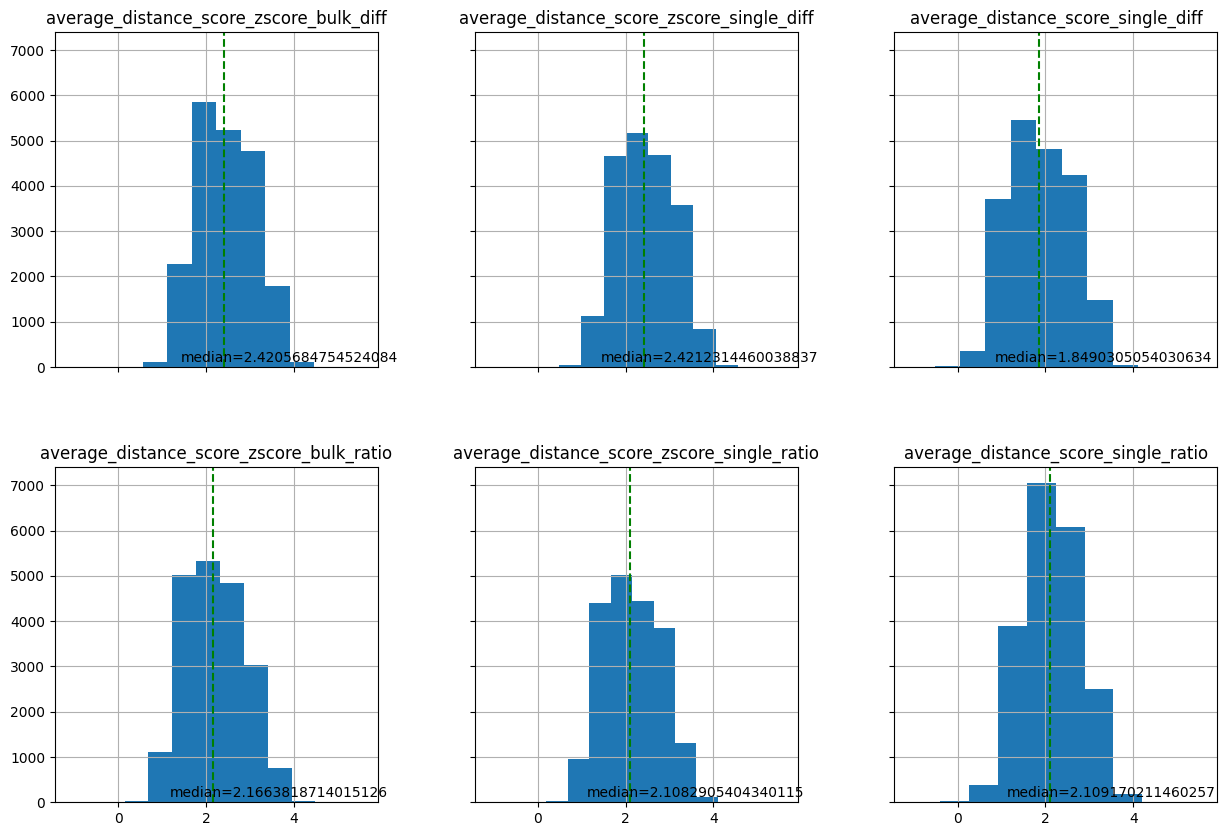

In [25]:
score_type = "average_distance"
histogram = merged_results[[
    f"{score_type}_score_zscore_bulk_diff",
    f"{score_type}_score_zscore_single_diff", 
    f"{score_type}_score_single_diff", 
    f"{score_type}_score_zscore_bulk_ratio", 
    f"{score_type}_score_zscore_single_ratio",
    f"{score_type}_score_single_ratio",
]].hist(sharex=True, sharey=True,figsize=(15, 10), layout=(2,3))

median_height = 120
add_median_to_histogram(result[f"{score_type}_score_zscore_bulk_diff"], histogram, 0, 0, median_height)
add_median_to_histogram(result[f"{score_type}_score_zscore_single_diff"], histogram, 0, 1, median_height)
add_median_to_histogram(result[f"{score_type}_score_single_diff"], histogram, 0, 2, median_height)

add_median_to_histogram(result[f"{score_type}_score_zscore_bulk_ratio"], histogram, 1, 0, median_height)
add_median_to_histogram(result[f"{score_type}_score_zscore_single_ratio"], histogram, 1, 1, median_height)
add_median_to_histogram(result[f"{score_type}_score_single_ratio"], histogram, 1, 2, median_height)

In [28]:
single_diff_negative = filtered_result[filtered_result["average_distance_score_single_diff"] < 0] 
single_ratio_negative = filtered_result[filtered_result["average_distance_score_single_ratio"] < 0] 

zscore_bulk_diff_negative = filtered_result[filtered_result["average_distance_score_zscore_bulk_diff"] < 0] 
zscore_bulk_ratio_negative = filtered_result[filtered_result["average_distance_score_zscore_bulk_ratio"] < 0]

zscore_single_diff_negative = filtered_result[filtered_result["average_distance_score_zscore_single_diff"] < 0] 
zscore_single_ratio_negative = filtered_result[filtered_result["average_distance_score_zscore_single_ratio"] < 0] 

print(f"{len(single_diff_negative)}, percentage:{len(single_diff_negative)/len(result) * 100}")
print(f"{len(single_ratio_negative)}, percentage:{len(single_ratio_negative)/len(result) * 100}")
print(f"{len(zscore_bulk_diff_negative)}, percentage:{len(zscore_bulk_diff_negative)/len(result) * 100}")
print(f"{len(zscore_bulk_ratio_negative)}, percentage:{len(zscore_bulk_ratio_negative)/len(result) * 100}")
print(f"{len(zscore_single_diff_negative)}, percentage:{len(zscore_single_diff_negative)/len(result) * 100}")
print(f"{len(zscore_single_ratio_negative)}, percentage:{len(zscore_single_ratio_negative)/len(result) * 100}")

21, percentage:0.1042131904123865
17, percentage:0.08436305890526526
0, percentage:0.0
0, percentage:0.0
0, percentage:0.0
0, percentage:0.0


average_distance_score_single_diff
0
average_distance_score_single_diff
0
average_distance_score_single_diff
0
average_distance_score_single_diff
0
average_distance_score_single_diff
0
average_distance_score_zscore_single_diff
0
average_distance_score_zscore_single_diff
0
average_distance_score_zscore_single_diff
0
average_distance_score_zscore_single_diff
0
average_distance_score_zscore_bulk_diff
0
average_distance_score_zscore_bulk_diff
0
average_distance_score_zscore_bulk_diff
0
average_distance_score_single_ratio
0
average_distance_score_single_ratio
0
average_distance_score_zscore_single_ratio
0


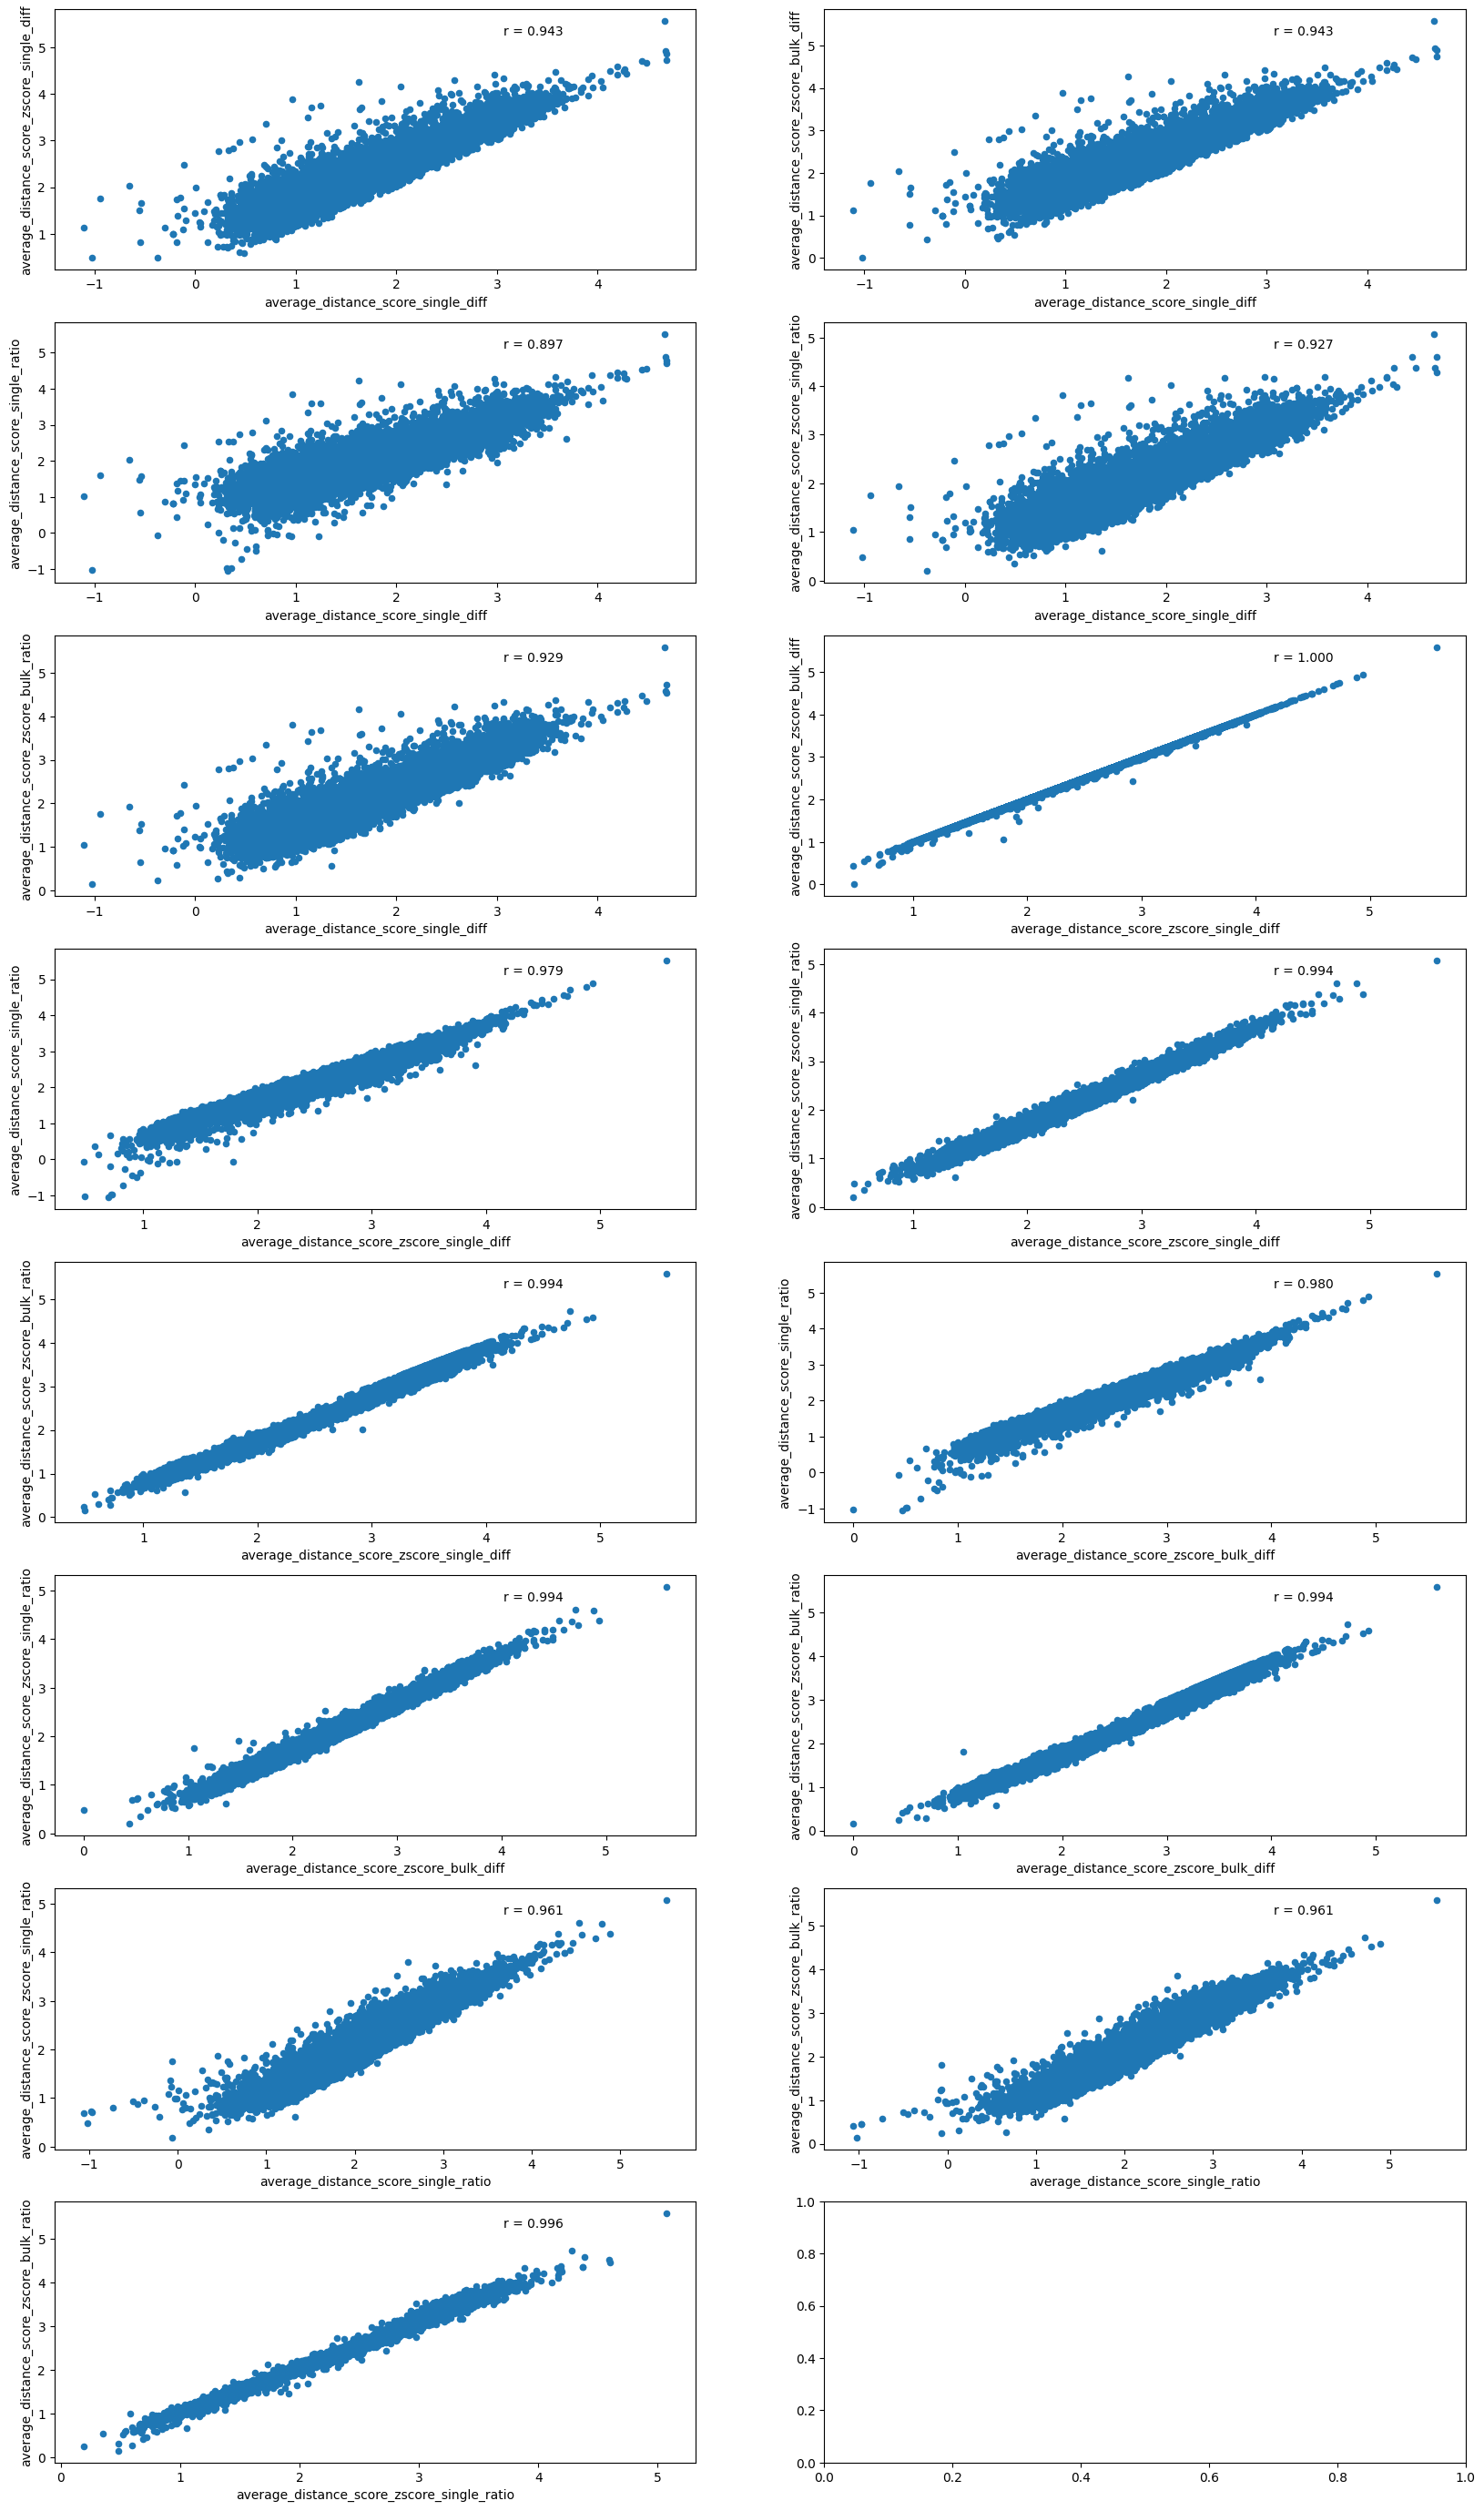

In [29]:
average_distance_score_variant_names = [s.format(score="average_distance_score") for s in variant_names]
plot_comparative_graphs(filtered_result, average_distance_score_variant_names)

In [ ]:
ratio_score_variant_names = [s.format(score="ratio_score") for s in variant_names]
plot_comparative_graphs(filtered_result, ratio_score_variant_names)

#### Escherichia-coli as unwanted host 

In [34]:
configuration = get_configuration(is_ecoli_optimized=False)
result, errors = get_scores_df_by_configuration_df(configuration)

results dir is: /tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/homo_sapiens/e_coli_optimized_False_bacillus_optimized_True/zscore_bulk_aa_ratio


Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, ini

results dir is: /tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/homo_sapiens/e_coli_optimized_False_bacillus_optimized_True/zscore_bulk_aa_diff


Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, ini

results dir is: /tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/homo_sapiens/e_coli_optimized_False_bacillus_optimized_True/zscore_single_aa_ratio


Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, ini

results dir is: /tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/homo_sapiens/e_coli_optimized_False_bacillus_optimized_True/zscore_single_aa_diff


Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, ini

results dir is: /tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/homo_sapiens/e_coli_optimized_False_bacillus_optimized_True/single_codon_ratio


Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, ini

results dir is: /tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/homo_sapiens/e_coli_optimized_False_bacillus_optimized_True/single_codon_diff


Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, ini

In [35]:
filtered_result = result[result["average_distance_score_zscore_bulk_ratio"].notna()]

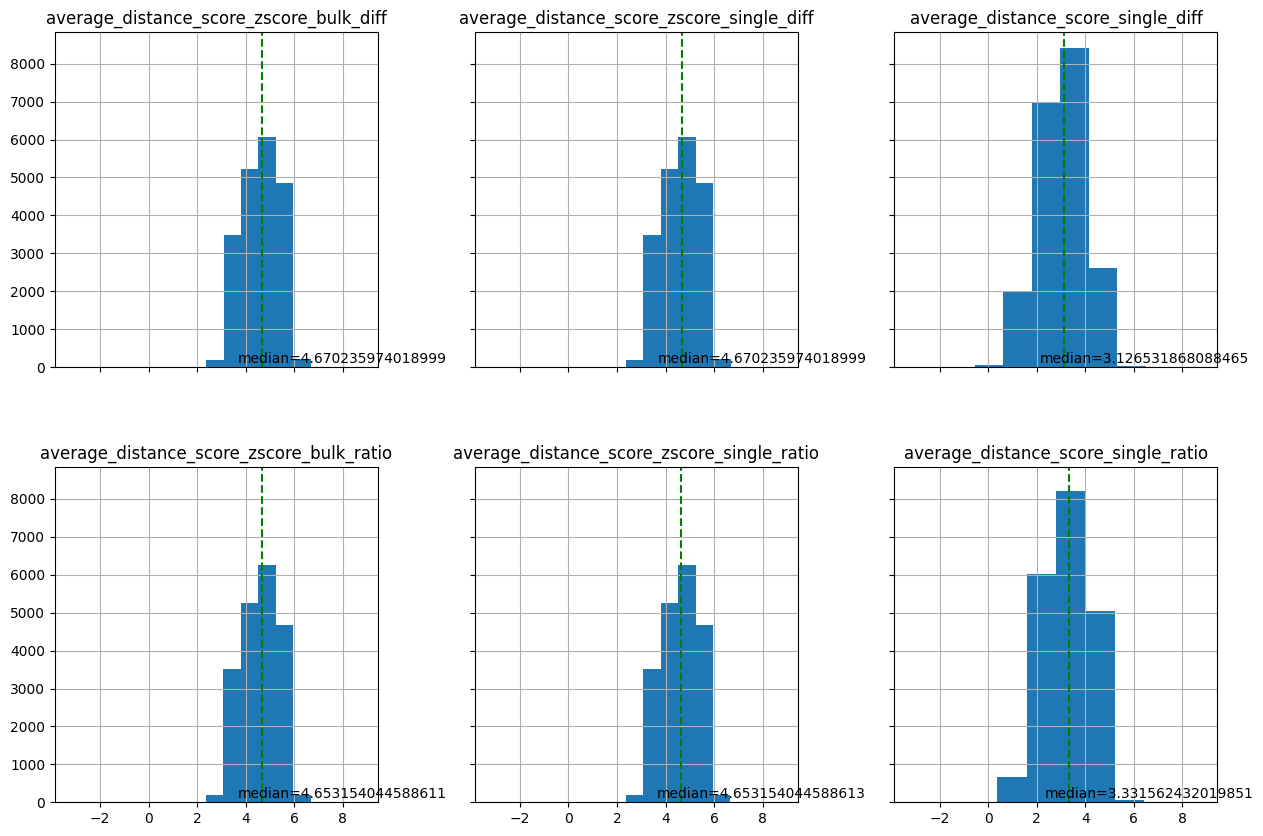

In [36]:
score_type = "average_distance"
histogram = filtered_result[[
    f"{score_type}_score_zscore_bulk_diff",
    f"{score_type}_score_zscore_single_diff", 
    f"{score_type}_score_single_diff", 
    f"{score_type}_score_zscore_bulk_ratio", 
    f"{score_type}_score_zscore_single_ratio",
    f"{score_type}_score_single_ratio",
]].hist(sharex=True, sharey=True,figsize=(15, 10), layout=(2,3))

median_height = 120
add_median_to_histogram(result[f"{score_type}_score_zscore_bulk_diff"], histogram, 0, 0, median_height)
add_median_to_histogram(result[f"{score_type}_score_zscore_single_diff"], histogram, 0, 1, median_height)
add_median_to_histogram(result[f"{score_type}_score_single_diff"], histogram, 0, 2, median_height)

add_median_to_histogram(result[f"{score_type}_score_zscore_bulk_ratio"], histogram, 1, 0, median_height)
add_median_to_histogram(result[f"{score_type}_score_zscore_single_ratio"], histogram, 1, 1, median_height)
add_median_to_histogram(result[f"{score_type}_score_single_ratio"], histogram, 1, 2, median_height)

average_distance_score_single_diff
0
average_distance_score_single_diff
0
average_distance_score_single_diff
0
average_distance_score_single_diff
0
average_distance_score_single_diff
0
average_distance_score_zscore_single_diff
0
average_distance_score_zscore_single_diff
0
average_distance_score_zscore_single_diff
0
average_distance_score_zscore_single_diff
0
average_distance_score_zscore_bulk_diff
0
average_distance_score_zscore_bulk_diff
0
average_distance_score_zscore_bulk_diff
0
average_distance_score_single_ratio
0
average_distance_score_single_ratio
0
average_distance_score_zscore_single_ratio
0


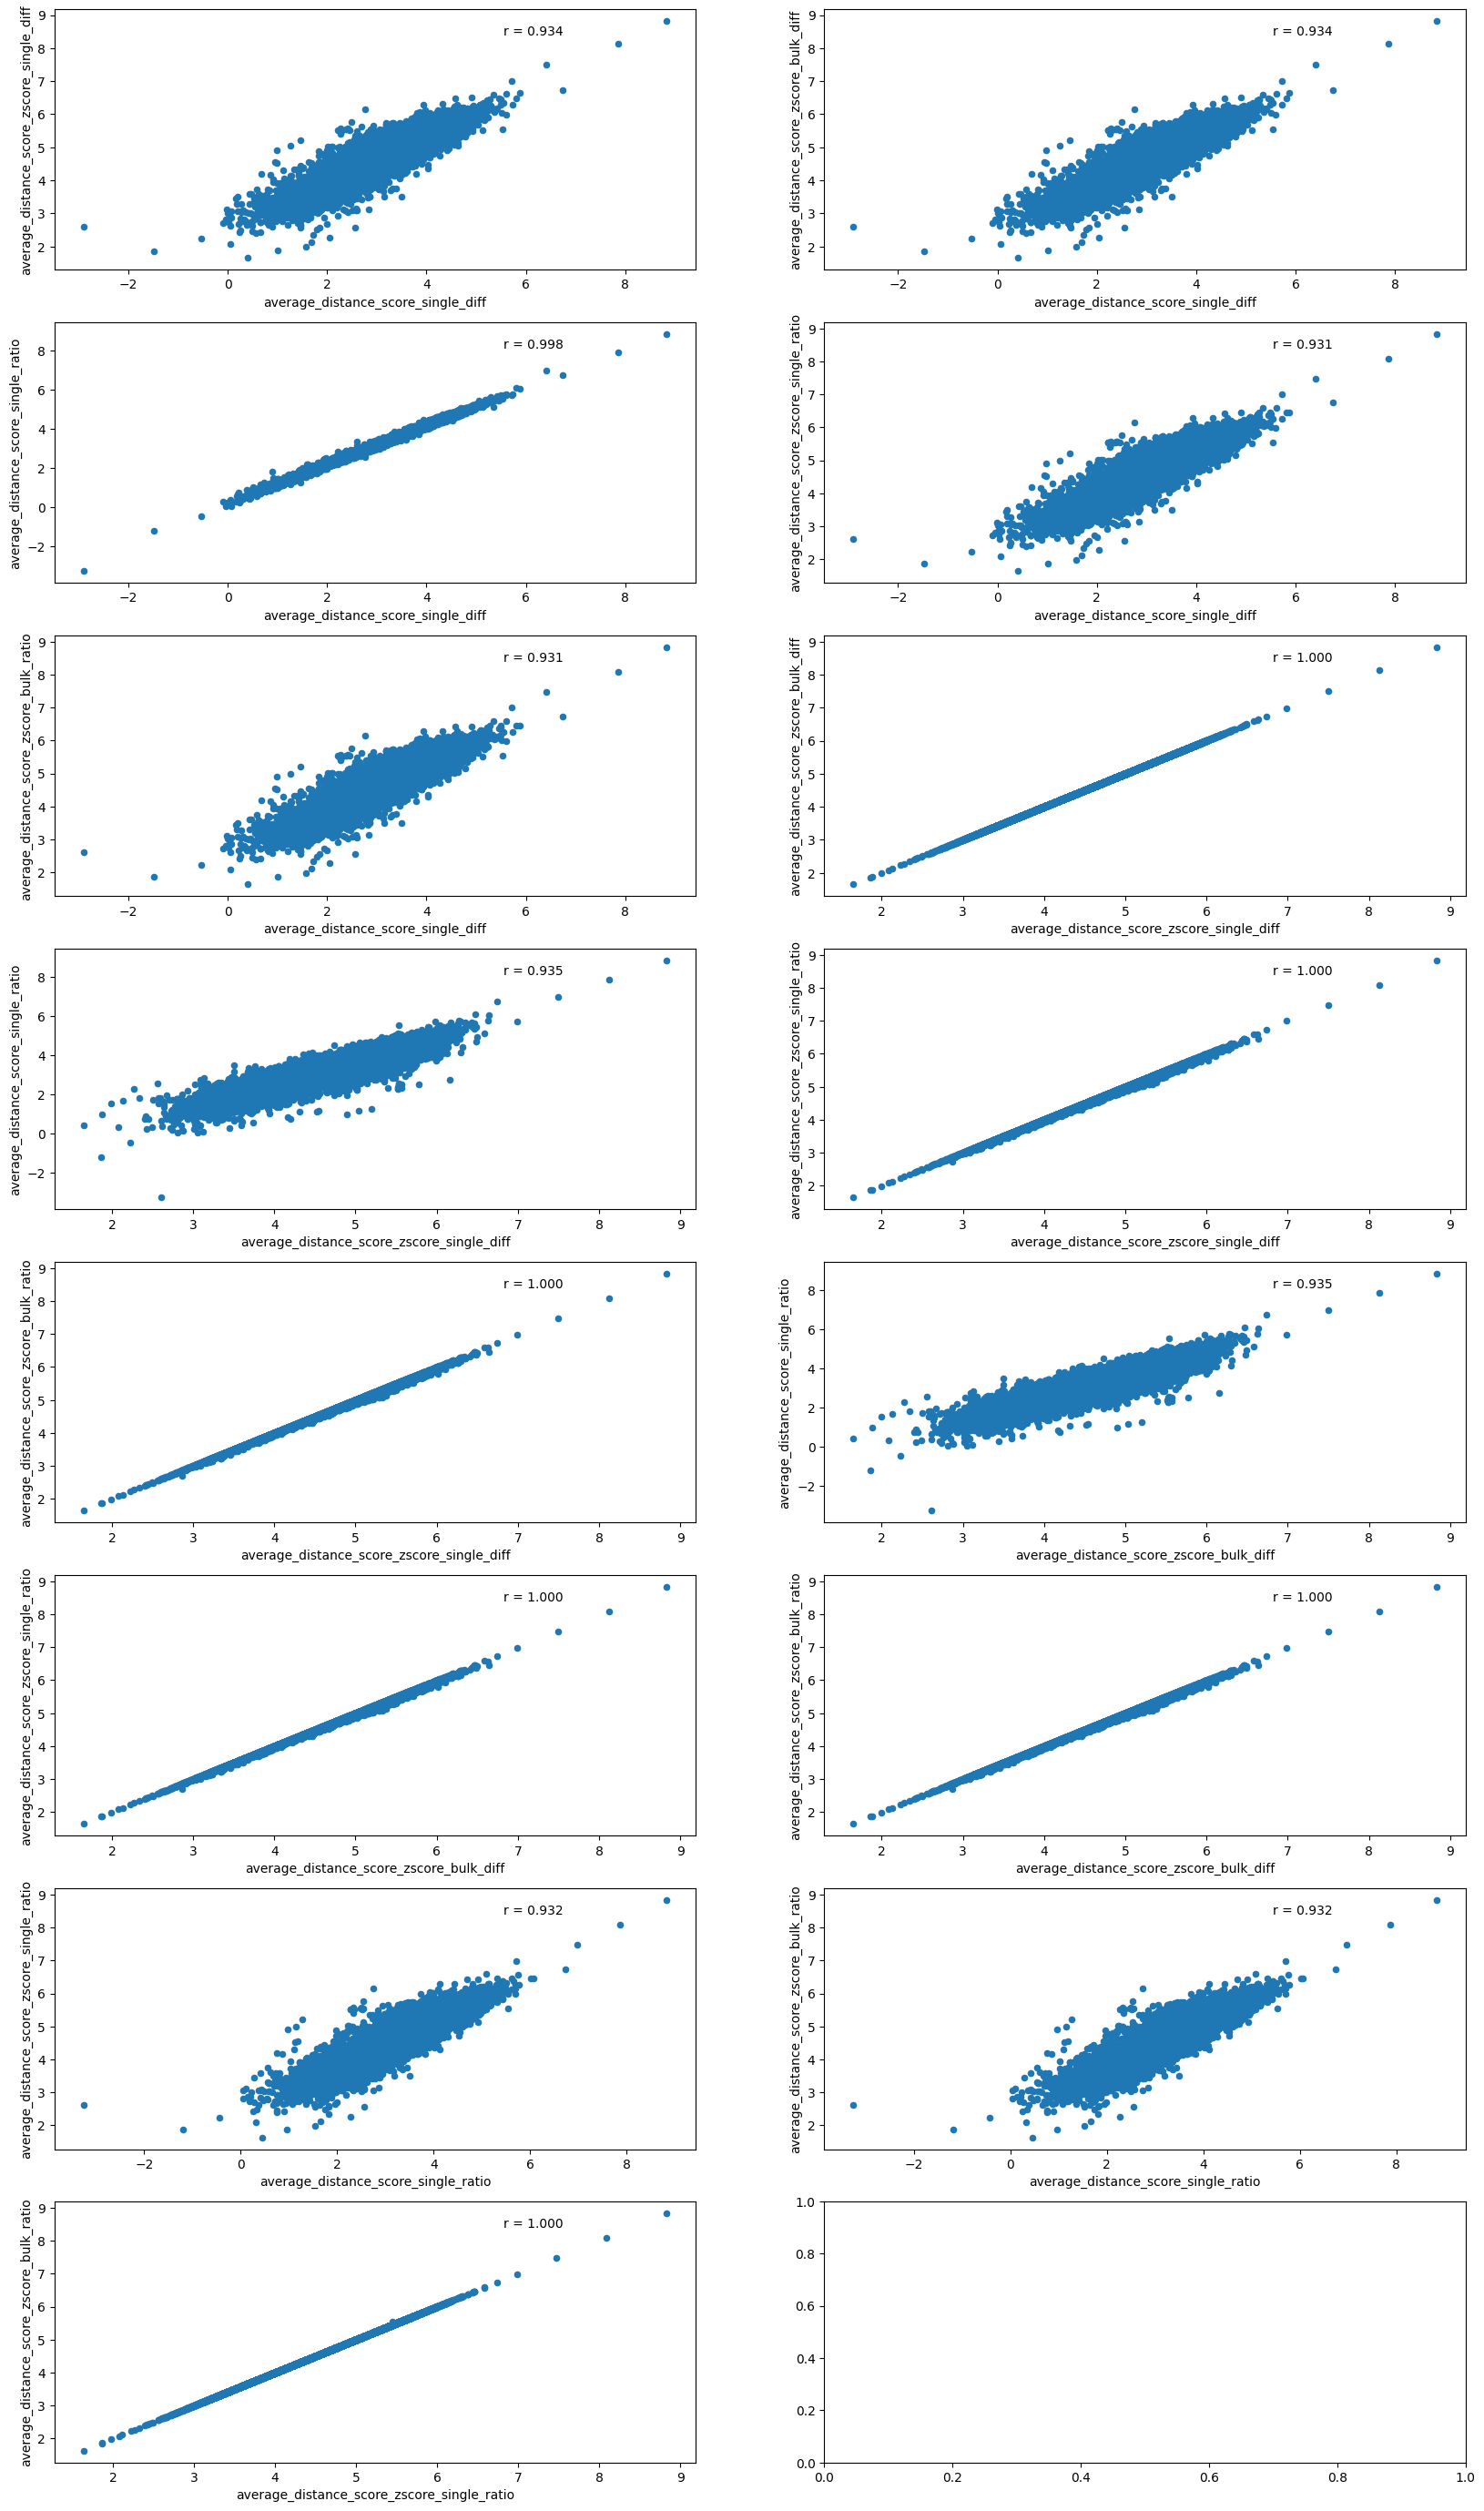

In [38]:
plot_comparative_graphs(result)

In [37]:
single_diff_negative = result[result["average_distance_score_single_diff"] < 0] 
single_ratio_negative = result[result["average_distance_score_single_ratio"] < 0] 

zscore_bulk_diff_negative = result[result["average_distance_score_zscore_bulk_diff"] < 0] 
zscore_bulk_ratio_negative = result[result["average_distance_score_zscore_bulk_ratio"] < 0]

zscore_single_diff_negative = result[result["average_distance_score_zscore_single_diff"] < 0] 
zscore_single_ratio_negative = result[result["average_distance_score_zscore_single_ratio"] < 0] 

print(f"{len(single_diff_negative)}, percentage:{len(single_diff_negative)/len(result) * 100}")
print(f"{len(single_ratio_negative)}, percentage:{len(single_ratio_negative)/len(result) * 100}")
print(f"{len(zscore_bulk_diff_negative)}, percentage:{len(zscore_bulk_diff_negative)/len(result) * 100}")
print(f"{len(zscore_bulk_ratio_negative)}, percentage:{len(zscore_bulk_ratio_negative)/len(result) * 100}")
print(f"{len(zscore_single_diff_negative)}, percentage:{len(zscore_single_diff_negative)/len(result) * 100}")
print(f"{len(zscore_single_ratio_negative)}, percentage:{len(zscore_single_ratio_negative)/len(result) * 100}")

6, percentage:0.029938625817074998
3, percentage:0.014969312908537499
0, percentage:0.0
0, percentage:0.0
0, percentage:0.0
0, percentage:0.0
